In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Torsion Lab Analysis Code ヽ(^o^)丿

## Define Dimension and Material Properties

In [3]:
from math import pi

#Specimen Dimensions
L = 0.18 ##Input the bar length from the lab manual##  # Length of Bar [m]
R = 0.00238##Input the bar radius from the lab manual##  # Radius of the Bar [m]
J = 5.04e-11##Calculate the polar 2nd moment of area## #Polar 2nd moment of area [m^4]

#Tensile Properties
E_al = 69e9##Input the Young's modulus from the tension lab##  # Young's Modulus [Pa]
nu_al= 0.33 ##Input the Poisson's ratio from the tension lab## # Poisson's ratio
s_y_al = 275e6 ##Input the yield strength from the tension lab## # Yield Strength [Pa]
#Shear Properties
G_th_al = E_al/2/(1+nu_al)  # Theoretical Shear Modulus [Pa]
tau_y_al = s_y_al/(3**0.5)   # Yield Shear Stress [Pa]

E_st = 200e9
nu_st = 0.26
s_y_st = 250e6
G_th_st = E_st/2/(1+nu_al)
tau_y_st = s_y_st/(3**0.5)

#Exponential Hardening Properties
H_al = 374e6##Input the H from the lab manual or your own fit to the tension data##  # Hardening coefficient [Pa]
n_al = 0.0417 ##Input the n from the lab manual or your own fit to the tension data## # Hardening exponent
               
H_st = 779e6
n_st = 0.194
print(G_th_al)
print(G_th_st)

25939849624.06015
75187969924.81203


## Plot experiment results of Torque vs Angle

### The data is stored in excel sheets
### Here we will extract it

In [4]:
import pandas as pd #remember that this is the data processing library

#File with all the data
dataFile = 'Torsion Data Aut2020.xlsx'

#Import the Steel Data
Steel1 = pd.read_excel(dataFile,header = 3,sheet_name = 'Data 1',usecols = [0,1])
Steel2 = pd.read_excel(dataFile,header = 3,sheet_name = 'Data 2',usecols = [0,1])

#Import the Aluminum Data
Aluminum1 = pd.read_excel(dataFile,header = 3,sheet_name = 'Data 1',usecols = [3,4])
Aluminum2 = pd.read_excel(dataFile,header = 3,sheet_name = 'Data 2',usecols = [3,4])

#Fix some weird stuff with the aluminum import
Aluminum1.columns = Steel1.columns #Rename the columns 
Aluminum1 = Aluminum1.dropna() #Drop NaN values
Aluminum2.columns = Steel2.columns #Rename the columns
Aluminum2 = Aluminum2.dropna() #Drop NaN values

### Now we can process it
### We will show the process for one of the steel data sets

In [5]:
from math import pi


Steel1['Angle (rad)'] = Steel1['Angle (deg)']*pi/180 #(rad)
Steel1['Force (N)'] = Steel1['Force (kgf)']*9.81
Steel1['Torque (Nm)'] = 0.131*Steel1['Force (N)']

Aluminum1['Angle (rad)'] = Aluminum1['Angle (deg)']*pi/180
Aluminum1['Force (N)'] = Aluminum1['Force (kgf)']*9.81
Aluminum1['Torque (Nm)'] = 0.131*Aluminum1['Force (N)']

Steel2['Angle (rad)'] = Steel2['Angle (deg)']*pi/180 #(rad)
Steel2['Force (N)'] = Steel2['Force (kgf)']*9.81
Steel2['Torque (Nm)'] = 0.131*Steel2['Force (N)']

Aluminum2['Angle (rad)'] = Aluminum2['Angle (deg)']*pi/180
Aluminum2['Force (N)'] = Aluminum2['Force (kgf)']*9.81
Aluminum2['Torque (Nm)'] = 0.131*Aluminum2['Force (N)']





### Plot the Results

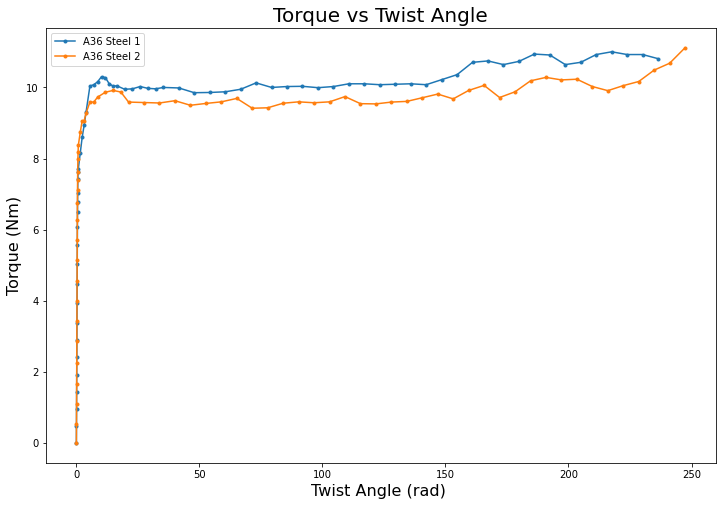

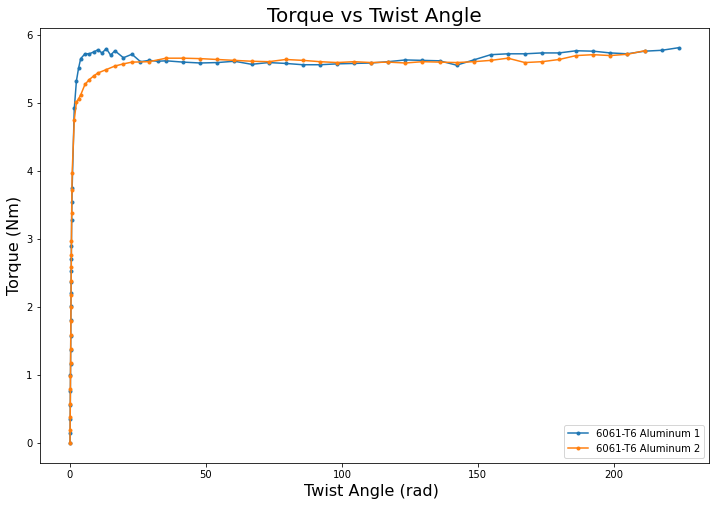

In [6]:
import matplotlib.pyplot as plt #Matlab-esque plotting library

#Plot the experimental torque vs twist angle
plt.figure(figsize = (12,8))
plt.plot(Steel1['Angle (rad)'],Steel1['Torque (Nm)'],'.-',label = 'A36 Steel 1')
plt.plot(Steel2['Angle (rad)'],Steel2['Torque (Nm)'],'.-',label = 'A36 Steel 2')
plt.xlabel('Twist Angle (rad) ',fontsize = 16)
plt.ylabel('Torque (Nm)',fontsize = 16)
plt.title('Torque vs Twist Angle', fontsize = 20)
plt.legend();


plt.figure(figsize = (12,8))
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Torque (Nm)'],'.-',label = '6061-T6 Aluminum 1')
plt.plot(Aluminum2['Angle (rad)'],Aluminum2['Torque (Nm)'],'.-',label = '6061-T6 Aluminum 2')
plt.xlabel('Twist Angle (rad) ',fontsize = 16)
plt.ylabel('Torque (Nm)',fontsize = 16)
plt.title('Torque vs Twist Angle', fontsize = 20)
plt.legend();



### Here are some useful functions to calculate the shear modulus from the data

In [7]:
from scipy.stats import linregress #This is a linear regression function built into the Scipy library. 
#You can call help(linregress) if you'd like to learn more. Or check out https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

def maxShearStress(torque,R,J):
    tauMax = (torque*R)/J
    return tauMax

def maxShearStrain(twist,R,L):
    gammaMax = (twist*R)/L##equation for the max shear strain based on the twist in the elastic region##
    return gammaMax

def shearModulusFit(twist,torque,R,L,J,a,b):
    '''This is a linear fit to data between the data indices for a and b. Note, this will
    return an error if a or b are outside the length of Strain and Stress.'''
    
    #Find shear stress and shear strain
    shearStrain = [maxShearStrain(x,R,L) for x in twist[a:b]]
    shearStress = [maxShearStress(x,R,J) for x in torque[a:b]]
    
    #Fit the modulus
    G,C,r,P,Err = linregress(shearStrain,shearStress) #The data outputs the slope (G), intercept (C), regression (r) value, P-value and standard error
    #Note: Python lets you save multivariable outputs with a comma, i.e. a,b=[1,2] will give a=1 and b=2
    
    #Make a line for the fit data
    Y = [0.0, max(shearStress)] #this is a list of length 2 for plotting the fit data later
    X = [(y-C)/G for y in Y] #these are points that you can plot to visualize the data being fit, inverted from y=G*x+C, x=(y-C)/G
    return G,C,r,X,Y

### Find the shear modulus from the torsion experiment
### Then compare it with the theoretical shear modulus from the stiffness obtained in the tension lab

0.9995933429812263


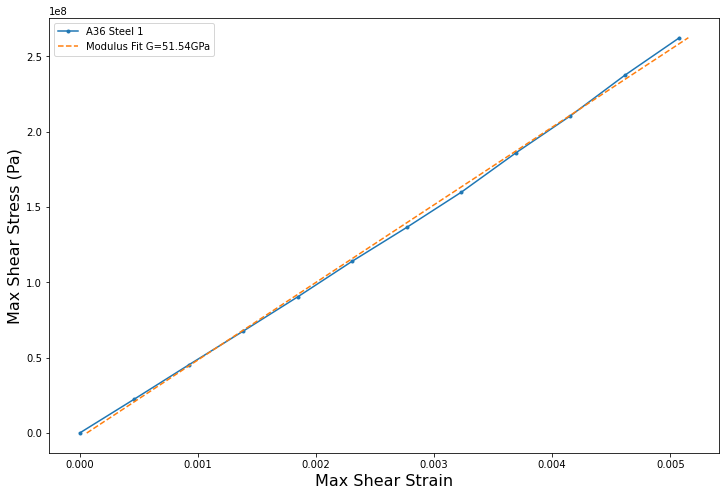

In [10]:
import matplotlib.pyplot as plt #Matlab-esque plotting library

#Fit to the loading data
a = 0
b = 12
G_st_1,C,r,X,Y = shearModulusFit(Steel1['Angle (rad)'].values,Steel1['Torque (Nm)'].values,R,L,J,a,b)

#Find the max shear stress and strain from elastic analysis
shearStrain = [maxShearStrain(x,R,L) for x in Steel1['Angle (rad)'][a:b]]
shearStress = [maxShearStress(x,R,J) for x in Steel1['Torque (Nm)'][a:b]]

#Plot the max shear stress and strain and fit
plt.figure(figsize = (12,8))
plt.plot(shearStrain,shearStress,'.-',label = 'A36 Steel 1')
plt.plot(X,Y,'--',label = 'Modulus Fit G='+str(round(G_st_1*1e-9,2))+'GPa')
plt.xlabel('Max Shear Strain',fontsize = 16)
plt.ylabel('Max Shear Stress (Pa)',fontsize = 16)
plt.legend();
print(r)

0.9999640573147783


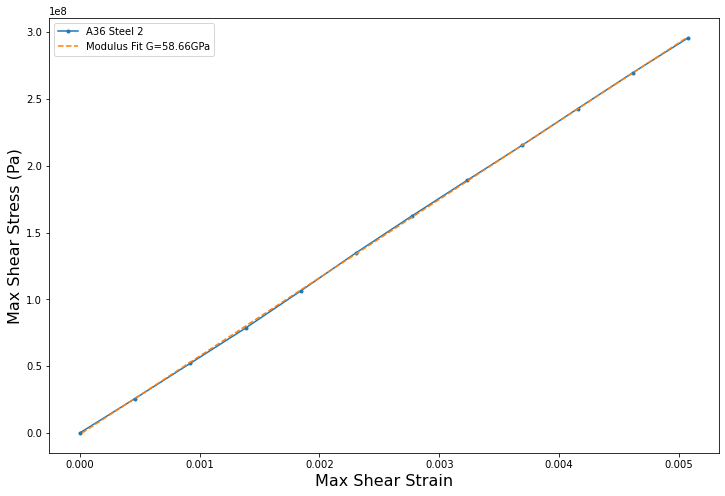

In [9]:
a = 0
b = 12
G_st_2,C,r,X,Y = shearModulusFit(Steel2['Angle (rad)'].values,Steel2['Torque (Nm)'].values,R,L,J,a,b)

#Find the max shear stress and strain from elastic analysis
shearStrain = [maxShearStrain(x,R,L) for x in Steel2['Angle (rad)'][a:b]]
shearStress = [maxShearStress(x,R,J) for x in Steel2['Torque (Nm)'][a:b]]

#Plot the max shear stress and strain and fit
plt.figure(figsize = (12,8))
plt.plot(shearStrain,shearStress,'.-',label = 'A36 Steel 2')
plt.plot(X,Y,'--',label = 'Modulus Fit G='+str(round(G_st_2*1e-9,2))+'GPa')
plt.xlabel('Max Shear Strain',fontsize = 16)
plt.ylabel('Max Shear Stress (Pa)',fontsize = 16)
plt.legend();
print(r)

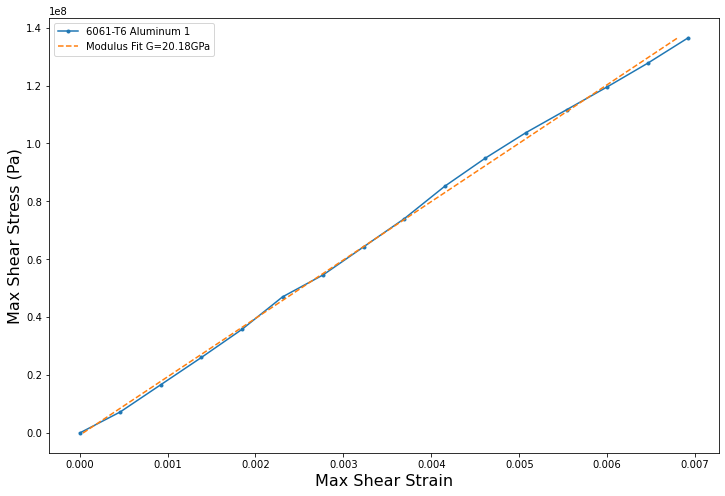

In [32]:
a = 0
b = 16
G_al_1,C,r,X,Y = shearModulusFit(Aluminum1['Angle (rad)'].values,Aluminum1['Torque (Nm)'].values,R,L,J,a,b)

#Find the max shear stress and strain from elastic analysis
shearStrain = [maxShearStrain(x,R,L) for x in Aluminum1['Angle (rad)'][a:b]]
shearStress = [maxShearStress(x,R,J) for x in Aluminum1['Torque (Nm)'][a:b]]

#Plot the max shear stress and strain and fit
plt.figure(figsize = (12,8))
plt.plot(shearStrain,shearStress,'.-',label = '6061-T6 Aluminum 1')
plt.plot(X,Y,'--',label = 'Modulus Fit G='+str(round(G_al_1*1e-9,2))+'GPa')
plt.xlabel('Max Shear Strain',fontsize = 16)
plt.ylabel('Max Shear Stress (Pa)',fontsize = 16)
plt.legend();

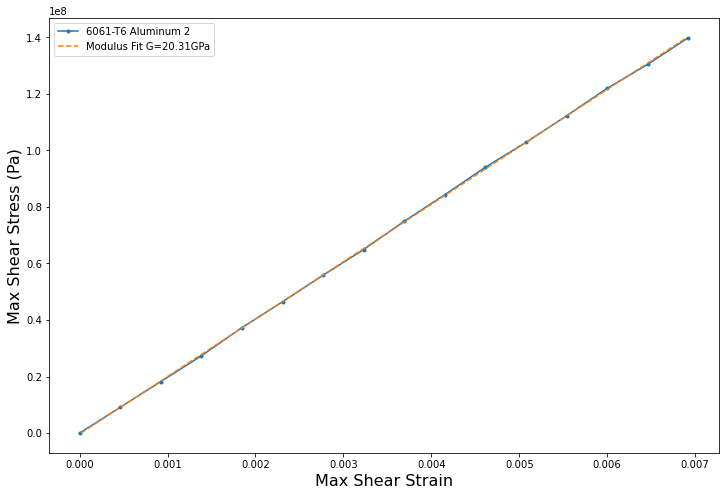

In [33]:
a = 0
b = 16
G_al_2,C,r,X,Y = shearModulusFit(Aluminum2['Angle (rad)'].values,Aluminum2['Torque (Nm)'].values,R,L,J,a,b)

#Find the max shear stress and strain from elastic analysis
shearStrain = [maxShearStrain(x,R,L) for x in Aluminum2['Angle (rad)'][a:b]]
shearStress = [maxShearStress(x,R,J) for x in Aluminum2['Torque (Nm)'][a:b]]

#Plot the max shear stress and strain and fit
plt.figure(figsize = (12,8))
plt.plot(shearStrain,shearStress,'.-',label = '6061-T6 Aluminum 2')
plt.plot(X,Y,'--',label = 'Modulus Fit G='+str(round(G_al_2*1e-9,2))+'GPa')
plt.xlabel('Max Shear Strain',fontsize = 16)
plt.ylabel('Max Shear Stress (Pa)',fontsize = 16)
plt.legend();

### Find the Yield Radius for every applied twist
### Remember that this is a theoretical calculation using the material properties obtained in the tension lab
### The big goal here is to compare theoretical plasticity predictions to experimental results

In [34]:
print(Steel1)

    Angle (deg)  Force (kgf)  Angle (rad)  Force (N)  Torque (Nm)
0             0        0.000     0.000000    0.00000     0.000000
1             2        0.370     0.034907    3.62970     0.475491
2             4        0.745     0.069813    7.30845     0.957407
3             6        1.115     0.104720   10.93815     1.432898
4             8        1.490     0.139626   14.61690     1.914814
..          ...          ...          ...        ...          ...
64        12105        8.500   211.272106   83.38500    10.923435
65        12465        8.560   217.555291   83.97360    11.000542
66        12825        8.500   223.838477   83.38500    10.923435
67        13185        8.500   230.121662   83.38500    10.923435
68        13545        8.410   236.404847   82.50210    10.807775

[69 rows x 5 columns]


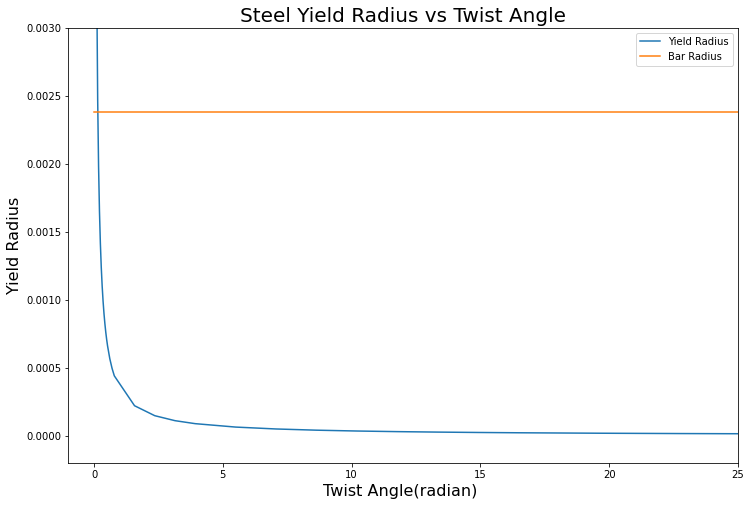

In [44]:
#Calculate the yield radius
Steel1['Theoretical Yield Radius (m)'] = (tau_y_st*L)/(G_th_st*Steel1['Angle (rad)'])##equation for yield radius, hint: use Data['Angle (rad)'] in the calculation##
#print(tau_y,L,G_th)
#Plot it to visualize
plt.figure(figsize = (12,8))
plt.plot(Steel1['Angle (rad)'],Steel1['Theoretical Yield Radius (m)'],label = 'Yield Radius')
plt.plot(Steel1['Angle (rad)'],[R]*len(Steel1),label='Bar Radius')
plt.ylim(-0.0002,0.003)
plt.xlim(-1,25)
plt.xlabel('Twist Angle(radian) ',fontsize = 16)
plt.ylabel('Yield Radius',fontsize = 16)
plt.title('Steel Yield Radius vs Twist Angle', fontsize = 20)
plt.legend();

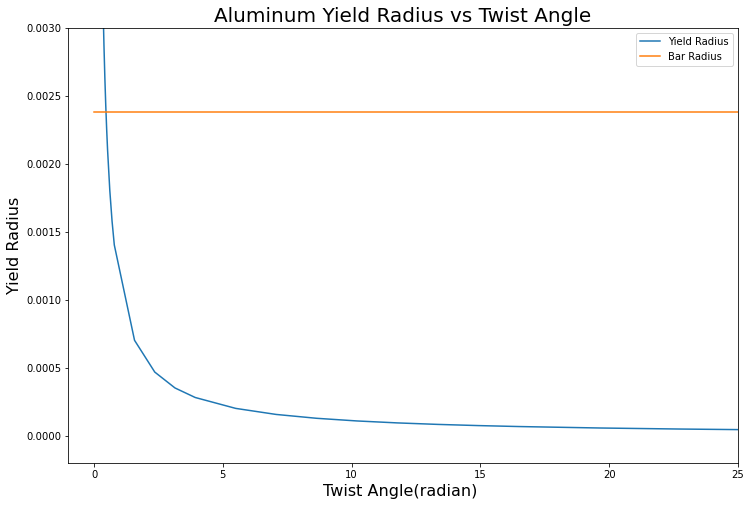

In [45]:
Aluminum1['Theoretical Yield Radius (m)'] = (tau_y_al*L)/(G_th_al*Aluminum1['Angle (rad)'])##equation for yield radius, hint: use Data['Angle (rad)'] in the calculation##
#print(tau_y,L,G_th)
#Plot it to visualize
plt.figure(figsize = (12,8))
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Theoretical Yield Radius (m)'],label = 'Yield Radius')
plt.plot(Aluminum1['Angle (rad)'],[R]*len(Aluminum1),label='Bar Radius')
plt.ylim(-0.0002,0.003)
plt.xlim(-1,25)
plt.xlabel('Twist Angle(radian) ',fontsize = 16)
plt.ylabel('Yield Radius',fontsize = 16)
plt.title('Aluminum Yield Radius vs Twist Angle', fontsize = 20)
plt.legend();

## Calculate the theoretical torque from the analytical plasticity model
### Reminder, the bar is theoretically still elastic when the yield radius is larger than the bar radius
### The bar becomes plastic when the yield radius is smaller than the bar radius

In [41]:
from math import pi,sqrt

# Finish these functions for the elastic and plastic components of torque
def elasticTorque(r_y,tau_y,G,L,R,theta):
    if r_y > R:
        T_Elastic = (pi*G*R**4*theta)/(2*L)
    else:
        T_Elastic = (pi*tau_y*r_y**3)/2
    return T_Elastic

def plasticTorque(r_y,H,n,L,R,theta):
    if r_y > R:
        T_Plastic = 0  
    else:
        T_Plastic = ((2*pi*H)/(sqrt(3)*(n+3)))*((theta/(sqrt(3)*L))**n)*(R**(n+3)-r_y**(n+3))
    return T_Plastic

def elasticPlasticTorque(r_y,tau_y,H,n,G,L,R,theta):
    T = elasticTorque(r_y,tau_y,G,L,R,theta) + plasticTorque(r_y,H,n,L,R,theta)
    return T

### Now let's calculate the theoretical torque for everything

In [43]:
#Initialize some empty variables

eTorque = []
pTorque = []
theoreticalTorque = []

for i in range(len(Steel1)):
    #Create dummy variables to make the code look cleaner
    r_y = Steel1['Theoretical Yield Radius (m)'].values[i]
    theta = Steel1['Angle (rad)'].values[i]
    
    #Run the functions we defined above
    eTorque += [elasticTorque(r_y,tau_y_st,G_th_st,L,R,theta)] #The += here is adding values to the list, e.g. a=[1]; a+=[2] -> a=[1,2]
    pTorque += [plasticTorque(r_y,H_st,n_st,L,R,theta)]
    theoreticalTorque += [elasticPlasticTorque(r_y,tau_y_st,H_st,n_st,G_th_st,L,R,theta)]

#And include the values in a Pandas dataframe
Steel1['Theoretical Elastic Torque (Nm)'] = eTorque
Steel1['Theoretical Plastic Torque (Nm)'] = pTorque
Steel1['Theoretical Torque (Nm)'] = theoreticalTorque

In [47]:
eTorque = []
pTorque = []
theoreticalTorque = []

for i in range(len(Aluminum1)):
    #Create dummy variables to make the code look cleaner
    r_y = Aluminum1['Theoretical Yield Radius (m)'].values[i]
    theta = Aluminum1['Angle (rad)'].values[i]
    
    #Run the functions we defined above
    eTorque += [elasticTorque(r_y,tau_y_al,G_th_al,L,R,theta)] #The += here is adding values to the list, e.g. a=[1]; a+=[2] -> a=[1,2]
    pTorque += [plasticTorque(r_y,H_al,n_al,L,R,theta)]
    theoreticalTorque += [elasticPlasticTorque(r_y,tau_y_al,H_al,n_al,G_th_al,L,R,theta)]

#And include the values in a Pandas dataframe
Aluminum1['Theoretical Elastic Torque (Nm)'] = eTorque
Aluminum1['Theoretical Plastic Torque (Nm)'] = pTorque
Aluminum1['Theoretical Torque (Nm)'] = theoreticalTorque

### As a brief aside, lets see what we've calculated for the material so far

In [48]:
#Calling the Pandas dataframe will output the results
Steel1

,Angle (deg),Force (kgf),Angle (rad),Force (N),Torque (Nm),Theoretical Yield Radius (m),Theoretical Elastic Torque (Nm),Theoretical Plastic Torque (Nm),Theoretical Torque (Nm)
0,0,0.000,0.000000,0.00000,0.000000,inf,0.000000e+00,0.000000,0.000000
1,2,0.370,0.034907,3.62970,0.475491,0.009899,7.348707e-01,0.000000,0.734871
2,4,0.745,0.069813,7.30845,0.957407,0.004950,1.469741e+00,0.000000,1.469741
3,6,1.115,0.104720,10.93815,1.432898,0.003300,2.204612e+00,0.000000,2.204612
4,8,1.490,0.139626,14.61690,1.914814,0.002475,2.939483e+00,0.000000,2.939483
...,...,...,...,...,...,...,...,...,...
64,12105,8.500,211.272106,83.38500,10.923435,0.000002,9.919353e-10,13.086525,13.086525
65,12465,8.560,217.555291,83.97360,11.000542,0.000002,9.084497e-10,13.161139,13.161139
66,12825,8.500,223.838477,83.38500,10.923435,0.000002,8.340760e-10,13.234036,13.234036
67,13185,8.500,230.121662,83.38500,10.923435,0.000002,7.676042e-10,13.305301,13.305301


## Now we can plot the theoretical vs experimental torque!
### We'll also make a plot to see the difference between the theoretical elastic and plastic torque
*Notes:*
- The data for the steel will likely give you strange results if you use the values provided in the manual, please look for an update on Canvas with updated properties.
- These fits are theoretical predictions using an exponential plasticity model. Part of what we're trying to see is how well we can use that theory to fit to real data.

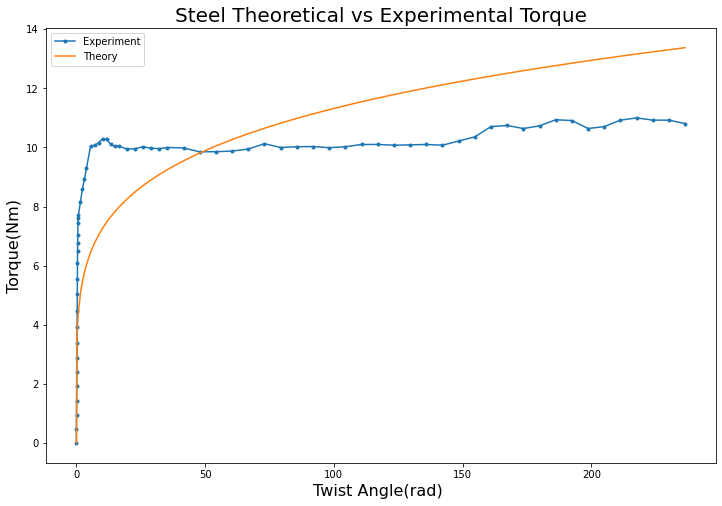

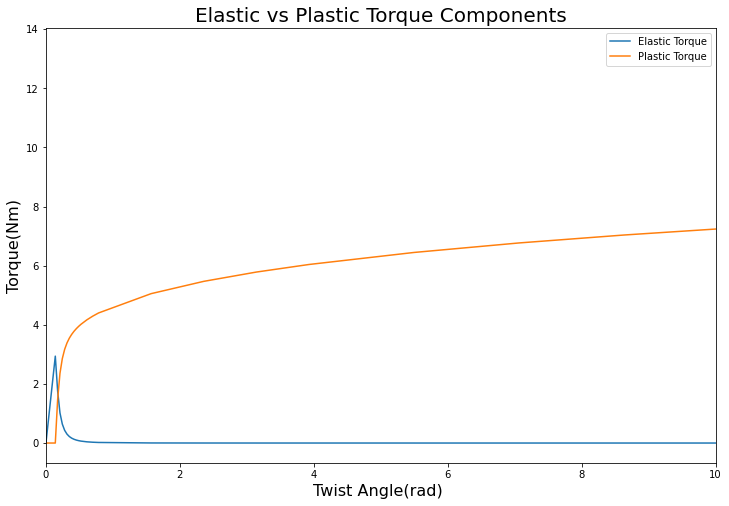

In [50]:
#Call the plot to make a new figure for the experimental vs theoretical torque v twist
plt.figure(figsize = (12,8))
plt.plot(Steel1['Angle (rad)'],Steel1['Torque (Nm)'],'.-',label = 'Experiment')
plt.plot(Steel1['Angle (rad)'],Steel1['Theoretical Torque (Nm)'],label = 'Theory')
plt.xlabel('Twist Angle(rad) ',fontsize = 16)
plt.ylabel('Torque(Nm)',fontsize = 16)
plt.title('Steel Theoretical vs Experimental Torque',fontsize=20)
plt.legend();

#Call a new plot to make a figure for the theoretical elastic vs plastic contribution to torque
plt.figure(figsize = (12,8))
plt.plot(Steel1['Angle (rad)'],Steel1['Theoretical Elastic Torque (Nm)'],label = 'Elastic Torque')
plt.plot(Steel1['Angle (rad)'],Steel1['Theoretical Plastic Torque (Nm)'],label = 'Plastic Torque')
plt.xlabel('Twist Angle(rad) ',fontsize = 16)
plt.ylabel('Torque(Nm)',fontsize = 16)
plt.title('Elastic vs Plastic Torque Components',fontsize=20)
plt.xlim([0,10]); #We'll zoom in on the twist here to get a closer look at the elastic component
plt.legend();


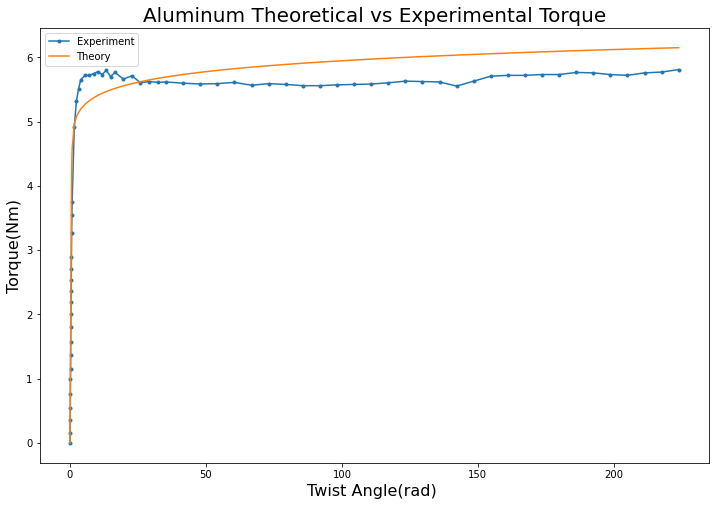

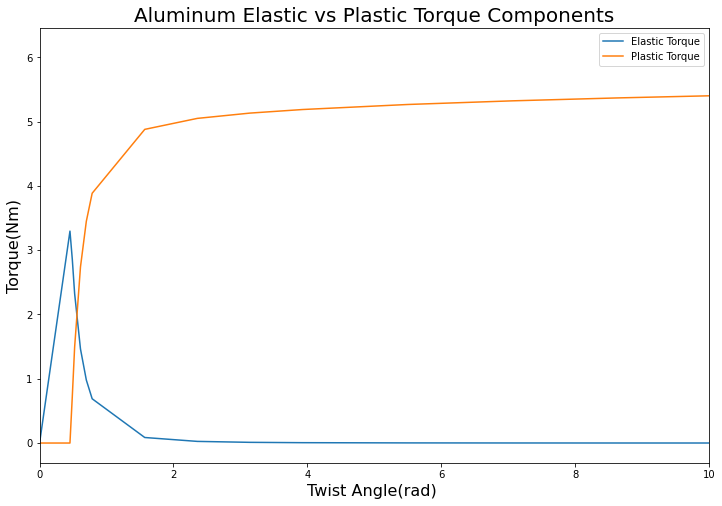

In [51]:
plt.figure(figsize = (12,8))
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Torque (Nm)'],'.-',label = 'Experiment')
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Theoretical Torque (Nm)'],label = 'Theory')
plt.xlabel('Twist Angle(rad) ',fontsize = 16)
plt.ylabel('Torque(Nm)',fontsize = 16)
plt.title('Aluminum Theoretical vs Experimental Torque',fontsize=20)
plt.legend();

#Call a new plot to make a figure for the theoretical elastic vs plastic contribution to torque
plt.figure(figsize = (12,8))
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Theoretical Elastic Torque (Nm)'],label = 'Elastic Torque')
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Theoretical Plastic Torque (Nm)'],label = 'Plastic Torque')
plt.xlabel('Twist Angle(rad) ',fontsize = 16)
plt.ylabel('Torque(Nm)',fontsize = 16)
plt.title('Aluminum Elastic vs Plastic Torque Components',fontsize=20)
plt.xlim([0,10]); #We'll zoom in on the twist here to get a closer look at the elastic component
plt.legend();

## Sensitivity Analysis of Hardening Coefficients
### Now we want to see how some variability in the coefficients affects the theoretical fit

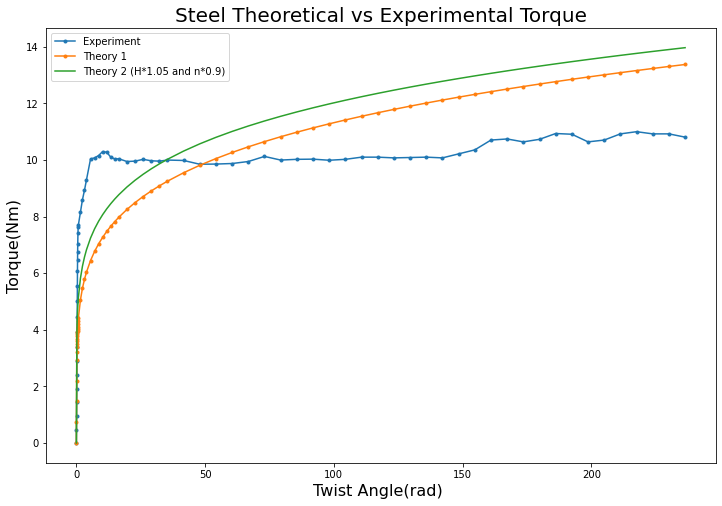

In [63]:
#Try increasing or decreasing the values of H and n to see what effect they have
H_st_2 = H_st*1.05; n_st_2 = n_st*0.9  # for example

#Then we rerun the theoretical torque calculation from before
#Initialize some empty variables
theoreticalTorque2 = []

for i in range(len(Steel1)):
    #Create dummy variables to make the code look cleaner
    r_y = Steel1['Theoretical Yield Radius (m)'].values[i]
    theta = Steel1['Angle (rad)'].values[i]
    
    #Run the functions we defined above
    theoreticalTorque2 += [elasticPlasticTorque(r_y,tau_y_st,H_st_2,n_st_2,G_th_st,L,R,theta)]

#And include the values in a Pandas dataframe
Steel1['Theoretical Torque 2 (Nm)'] = theoreticalTorque2

plt.figure(figsize = (12,8))
plt.plot(Steel1['Angle (rad)'],Steel1['Torque (Nm)'],'.-',label = 'Experiment')
plt.plot(Steel1['Angle (rad)'],Steel1['Theoretical Torque (Nm)'],'.-',label = 'Theory 1')
plt.plot(Steel1['Angle (rad)'],Steel1['Theoretical Torque 2 (Nm)'],label = 'Theory 2 (H*1.05 and n*0.9)')
plt.xlabel('Twist Angle(rad) ',fontsize = 16)
plt.ylabel('Torque(Nm)',fontsize = 16)
plt.title('Steel Theoretical vs Experimental Torque',fontsize=20)
plt.legend();



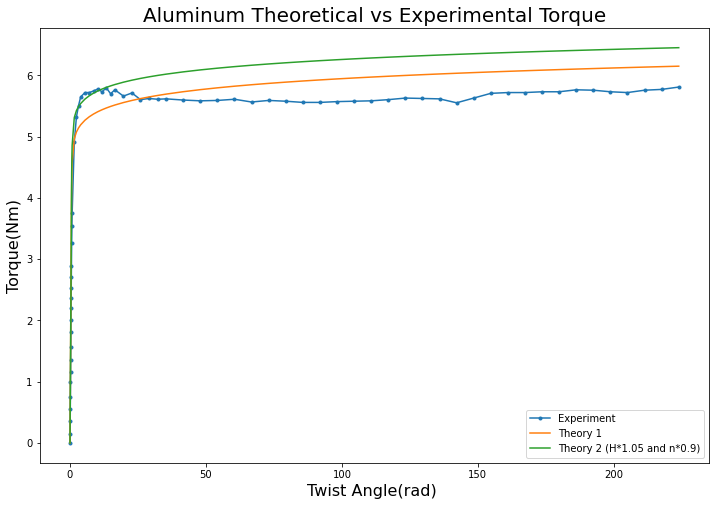

In [60]:
H_al_2 = H_al*1.05; n_al_2 = n_al*0.9  # for example

#Then we rerun the theoretical torque calculation from before
#Initialize some empty variables
theoreticalTorque2 = []

for i in range(len(Aluminum1)):
    #Create dummy variables to make the code look cleaner
    r_y = Aluminum1['Theoretical Yield Radius (m)'].values[i]
    theta = Aluminum1['Angle (rad)'].values[i]
    
    #Run the functions we defined above
    theoreticalTorque2 += [elasticPlasticTorque(r_y,tau_y_al,H_al_2,n_al_2,G_th_al,L,R,theta)]

#And include the values in a Pandas dataframe
Aluminum1['Theoretical Torque 2 (Nm)'] = theoreticalTorque2

plt.figure(figsize = (12,8))
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Torque (Nm)'],'.-',label = 'Experiment')
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Theoretical Torque (Nm)'],label = 'Theory 1')
plt.plot(Aluminum1['Angle (rad)'],Aluminum1['Theoretical Torque 2 (Nm)'],label = 'Theory 2 (H*1.05 and n*0.9)')
plt.xlabel('Twist Angle(rad) ',fontsize = 16)
plt.ylabel('Torque(Nm)',fontsize = 16)
plt.title('Aluminum Theoretical vs Experimental Torque',fontsize=20)
plt.legend();



### You can then adjust H and n and **plot the results together** with clear label of how you are changing the coefficient

## Hardening Fit
### If you want to do a fit to the hardening data, take the tension data and look at log fitting the plastic yield
#### We will not be giving you code here because this is extra credit
#### Here's a quick rundown of the process:
- Plot the loglog of the stress-strain data for the aluminum or steel
- Plot a marker for the yield point and the ultimate stress
- Determine a suitable "linear" region in that data to fit a hardening slope to
- Take a linear fit of the log of the stress and strain for that section of the data (s = H.e^n, log(s)=log(H)+n.log(e))
- Plot that fit in loglog space to be sure it's adequately capturing the "linear" region of the data